<a href="https://colab.research.google.com/github/victorcharpentier/Anapix/blob/main/VPC_Clustering_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install neptune-client
#!pip install neptune-neptune_pytorch_lightning

NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMDhiZDBkMC1jMjhkLTQ0YjgtYmVlYS02Y2E0ZThmNDY3NjIifQ=="


!pip install pytorch-lightning

#!pip install -U git+https://github.com/albumentations-team/albumentations_experimental


import psutil
import ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler, SGD

import os

import albumentations as A
from albumentations.pytorch import ToTensor

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning import loggers
from pytorch_lightning.metrics.functional import accuracy, auroc, recall, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_score

from collections import OrderedDict
import matplotlib.pyplot as plt

     |████████████████████████████████| 819kB 5.3MB/s 
     |████████████████████████████████| 829kB 18.9MB/s 
     |████████████████████████████████| 122kB 26.8MB/s 
     |████████████████████████████████| 645kB 25.4MB/s 
     |████████████████████████████████| 235kB 31.8MB/s 
     |████████████████████████████████| 10.6MB 39.3MB/s 
     |████████████████████████████████| 1.3MB 33.3MB/s 
     |████████████████████████████████| 296kB 42.7MB/s 
     |████████████████████████████████| 143kB 50.9MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=77f4257b239f4401b3312e7b438d0c07b63fcd598059cc388bea2a4fb23fe72a
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/Anapix/

/content/gdrive/My Drive/Anapix


In [4]:
images_path = 'vpc_autocropped_224/'

In [5]:
class ResnetMulti9cl(LightningModule):  #récupération de notre modèle
        def __init__(self, hparams):
          super().__init__()
          self.save_hyperparameters(hparams)
          self.batch_size = hparams['batch_size']
          self.lr = hparams['lr']
          self.workers = hparams['workers']
          self.test_results = []
          self.test_labels = []
          
          self.model = models.resnet50(pretrained=True)
          self.num_features = self.model.fc.in_features
          self.model.fc = torch.nn.Linear(self.num_features, 512)



        def forward_once(self, x):
          output = self.model(x)
          return output
    

        def forward(self, input1, input2):
          output1 = self.forward_once(input1)
          output2 = self.forward_once(input2)
          euclidean_distance = F.pairwise_distance(output1, output2)
          return euclidean_distance

ckpt_path_198_TES_5 = 'siamese/TES-5/checkpoints/epoch=9-step=11739.ckpt'
model_198_TES_5 = ResnetMulti9cl.load_from_checkpoint(checkpoint_path=ckpt_path_198_TES_5)
model_198_TES_5.freeze()  #blocage des neurones aléatoires

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
model = model_198_TES_5

data_train = pd.read_csv('new_train_consensus_yanal.csv',
index_col=[0,1,2])

data_train.drop(199, axis=0, inplace=True)#enlever le patient 199 car on a pas ses images

patient_id=0
for index, row in data_train.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    print("patient_id : "+str(patient_id)+" index : "+str(index[0]))
    patient_infos = data_train.loc[index[0]]
    patient_id_index=[]
    path1_index=[]
    path2_index=[]
    for index1, row in patient_infos.iterrows():

      patient_id_index.append(index[0])
      path1_index.append(index1[0])
      path2_index.append(index1[1])

      img_name1 = images_path + index1[0]
      image1 = cv2.imread(img_name1)
      image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
      image1 = image1/255
      image1 = ToTensor()(image=image1)['image'].float()
      image1 = image1.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle  

      img_name2 = images_path + index1[1]
      image2 = cv2.imread(img_name2)
      image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
      image2 = image2/255
      image2 = ToTensor()(image=image2)['image'].float()
      image2 = image2.unsqueeze(0)   #récupération et préparation de l'image pour le traitement par la modèle 


      prediction = 1 - model.forward(image1, image2)
      if prediction<0:
        prediction=0
      if prediction>1:
        prediction=1

      print(img_name1+" + "+img_name2)

      patient_infos.loc[index1,'concensus']=float(prediction)

    patient_infos.insert(0,"patient_id",patient_id_index,True)
    patient_infos.insert(1,"path1",path1_index,True)
    patient_infos.insert(2,"path2",path2_index,True)
    patient_infos.set_index(['patient_id','path1','path2'], inplace = True)

    if patient_id == 0:
      data_patients=patient_infos
      print("data_patients")
      print(data_patients)
    else:
      nouveau_patient = patient_infos
      data_patients = pd.concat([data_patients, nouveau_patient], join='outer') #on rajoute les patient au fur et à mesure
      print(data_patients)

  patient_id = index[0] #on change de patient
  print("nouveau patient : "+str(patient_id))

data_patients.to_csv("data_patients_deep_learning.csv", index=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


patient_id : 0 index : 126


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 34
nouveau patient : 3

                                   consensus  concensus
patient_id path1      path2                            
126        P126I1.JPG P126I1.JPG           9   0.999977
                      P126I10.JPG          0   0.000000
                      P126I11.JPG          0   0.000000
                      P126I12.JPG          0   0.000000
                      P126I13.JPG          0   0.000000
...                                      ...        ...
68         P68I9.JPG  P68I5.JPG            3   0.341370
                      P68I6.JPG            7   0.636497
                      P68I7.JPG            4   0.494350
                      P68I8.JPG            8   0.521222
                      P68I9.JPG            9   0.999977

[21704 rows x 2 columns]
patient_id : 126


No handles with labels found to put in legend.


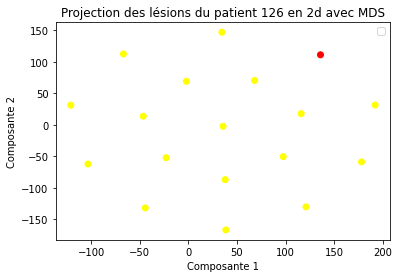

la prediction est la suivante : [3 1 1 1 1 1 2 2 2 1 2 1 1 1 1 1 1 1]
la liste des clusters est : [[1, 2, 3, 4, 5, 9, 11, 12, 13, 14, 15, 16, 17], [6, 7, 8, 10], [0]]
les index des VPC sont : [0]
Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 0 faux positifs
patient_id : 127


No handles with labels found to put in legend.


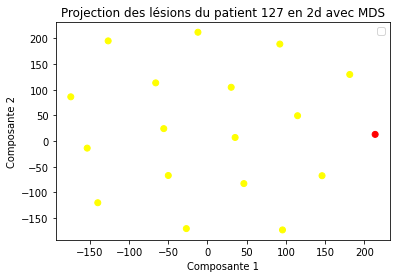

la prediction est la suivante : [3 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1]
la liste des clusters est : [[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], [1, 4], [0]]
les index des VPC sont : [0]
Le clustering unique trouve 1 unique dont 1 sur 1 VPC et 0 faux positifs
Le clustering unique et petits clusters trouve 1 VPC sur 1 dont 2 faux positifs
patient_id : 13


No handles with labels found to put in legend.


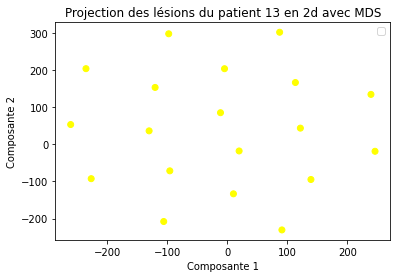

la prediction est la suivante : [3 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1]
la liste des clusters est : [[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18], [6, 16], [0]]
les index des VPC sont : []
Le clustering unique trouve 1 unique dont 0 sur 0 VPC et 1 faux positifs
Le clustering unique et petits clusters trouve 0 VPC sur 0 dont 3 faux positifs
patient_id : 131


KeyError: ignored

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, inconsistent, fcluster
from pandas import DataFrame
import networkx as nx
from sklearn import manifold

nb_cas_silhouette_b3=0
nb_VPC_identifiés_par_cluster_unique=0
nb_VPC_identifiés_par_cluster_unique_et_petit_cluster=0
nb_VPC_total=0
nb_faux_VPC_unique=0
nb_faux_VPC_petit_cluster=0
nb_images=0
nb_testés_total=0

data_patients = pd.read_csv('data_patients_deep_learning.csv',
index_col=[0,1,2])
print(data_patients)

patient_id=0

patients_train_clustering_par_predicteurs=pd.read_csv('patients_train_clustering_par_predicteurs.csv')
patients_train_clustering_par_predicteurs.set_index('patient_id',inplace=True)

for index, row in data_patients.iterrows():
  if patient_id!=index[0]: #lorsqu'on change de patient
    print("patient_id : "+str(index[0]))
    data_label = patients_train_clustering_par_predicteurs.loc[index[0]]
    Y = DataFrame(data_label['concensus'], columns = ['concensus'])
    Y['concensus'][Y['concensus'] == 0] = "red"
    Y['concensus'][Y['concensus'] != "red"] = "yellow"
    y=[]
    for i ,row in Y.iterrows():
      y.append(row[0])

    nb_images=nb_images+len(y)

    patient_infos = data_patients.loc[index[0]]
    patient = patient_infos.unstack()

    tsne = manifold.TSNE(n_components=2)
    mds = manifold.MDS(n_components=2)
    projectedMDS = tsne.fit_transform(patient)
    plt.scatter(projectedMDS[:, 0], projectedMDS[:, 1], c=y)
    plt.title("Projection des lésions du patient " +str(index[0])+ " en 2d avec MDS")
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    plt.legend()
    plt.show()

    linked = linkage(patient, "centroid")
    
    silhouette_vals=[]

    K = range(3,6) #test de 2 à 5 clusters
    for o in K:
      labels=fcluster(linked, o, "maxclust")
      silhouette_vals.append(np.mean(silhouette_score(patient,labels)))

    idx_max=0
    max=-1
    for k in range(len(silhouette_vals)): #on retrouve le nombre de clusters maximisant la silhouette
      if silhouette_vals[k]>max:
        max=silhouette_vals[k]
        idx_max=k

    prediction = fcluster(linked, idx_max+3, "maxclust")    #l'on utilise le nombre de clusters maximisant la silhouette
    print("la prediction est la suivante : "+str(prediction))

    index_VPC=[]
    nb_testés=0
    nb_clusters=len(np.unique(prediction)) #nombre de clusters dans la prediction
    liste_clusters=[]
    for e in range(nb_clusters):
      liste_clusters.append([])

    for a in range(len(y)):
      if y[a]=="red":
        index_VPC.append(a) #index des VPC
      liste_clusters[prediction[a]-1].append(a) #liste des index par cluster

    print("la liste des clusters est : "+str(liste_clusters))
    print("les index des VPC sont : "+str(index_VPC))
    
    clusters_unique=[]
    for g in range (nb_clusters):
      if len(liste_clusters[g])==1:
        nb_testés=nb_testés+1
        nb_testés_total=nb_testés_total+1
        clusters_unique.append(liste_clusters[g][0]) #on récupère les index de clusters uniques
    
    nb_trouvés_unique=0
    for l in index_VPC:
      if l in clusters_unique:
        nb_trouvés_unique=nb_trouvés_unique+1 #on comptabilise les clusters uniques étant réellement des VPC 
    
    nb_VPC_identifiés_par_cluster_unique=nb_VPC_identifiés_par_cluster_unique + nb_trouvés_unique
    nb_faux_VPC_unique=nb_faux_VPC_unique+len(clusters_unique)-nb_trouvés_unique

    print("Le clustering unique trouve "+str(len(clusters_unique))+ " unique dont "+str(nb_trouvés_unique)+" sur "+str(len(index_VPC))+ " VPC et " + str(len(clusters_unique)-nb_trouvés_unique)+ " faux positifs")

    #dans un second temps on identifie les clusters possédant moins de x d'individus et on regarde le nombre de VPC à l'intérieur

    nb_VPC_total = nb_VPC_total + len(index_VPC)

    nb_trouvés_petit_cluster=0
    nb_cas_petit_cluster=0
    liste_index_petit_clusters=[]
    for r in range(len(liste_clusters)):
      if 1<len(liste_clusters[r])<=3:
        nb_cas_petit_cluster=nb_cas_petit_cluster+len(liste_clusters[r])
        nb_testés=nb_testés+len(liste_clusters[r])
        nb_testés_total=nb_testés_total+len(liste_clusters[r])
        liste_index_petit_clusters.append(r) #on rajoute tout les petits clusters dans une liste
    
    for g in liste_index_petit_clusters:
      for h in liste_clusters[g]:
        if h in index_VPC:          #on regarde s'il y a des VPC dans les petits clusters
          nb_trouvés_petit_cluster=nb_trouvés_petit_cluster+1

    nb_faux_VPC_petit_cluster = nb_faux_VPC_petit_cluster + nb_cas_petit_cluster - nb_trouvés_petit_cluster
    nb_VPC_identifiés_par_cluster_unique_et_petit_cluster = nb_VPC_identifiés_par_cluster_unique_et_petit_cluster + nb_trouvés_unique +nb_trouvés_petit_cluster

    print("Le clustering unique et petits clusters trouve "+str(nb_trouvés_unique+nb_trouvés_petit_cluster)+" VPC sur "+str(len(index_VPC))+ " dont " + str(nb_testés-nb_trouvés_unique-nb_trouvés_petit_cluster)+ " faux positifs")



  patient_id = index[0] #on change de patient

  
rappel_cluster_unique=(nb_VPC_identifiés_par_cluster_unique/nb_VPC_total)*100
precision_cluster_unique=((nb_VPC_identifiés_par_cluster_unique)/(nb_faux_VPC_unique+nb_VPC_identifiés_par_cluster_unique))*100 #définition des scores
f1_cluster_unique=2*(rappel_cluster_unique*precision_cluster_unique)/(rappel_cluster_unique+precision_cluster_unique)

rappel_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/nb_VPC_total)*100
precision_unique_petit_cluster=(nb_VPC_identifiés_par_cluster_unique_et_petit_cluster/(nb_faux_VPC_unique+nb_faux_VPC_petit_cluster+nb_VPC_identifiés_par_cluster_unique_et_petit_cluster))*100
f1__unique_petit_cluster=2*(rappel_unique_petit_cluster*precision_unique_petit_cluster)/(rappel_unique_petit_cluster+precision_unique_petit_cluster)

fp=nb_testés_total-nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
vp=nb_VPC_identifiés_par_cluster_unique_et_petit_cluster
fn=nb_faux_VPC_unique+nb_faux_VPC_petit_cluster
vn=nb_images -fp-vp-fn


print("Pour les clusters uniques, rappel : "+ str(rappel_cluster_unique) + " % précision : "+str(precision_cluster_unique) + " % et f1 = "+str(f1_cluster_unique))
print("Pour les clusters uniques + petit cluster , rappel : "+ str(rappel_unique_petit_cluster) + " % précision : "+str(precision_unique_petit_cluster) + " % et f1 = "+str(f1__unique_petit_cluster))
print("Pour les clusters uniques + petit cluster , spécificité : "+ str((vn)*100/(vn+fp))+ " % ")
print("nb_VPC_total : "+str(nb_VPC_total))
print("nb_images : "+str(nb_images))

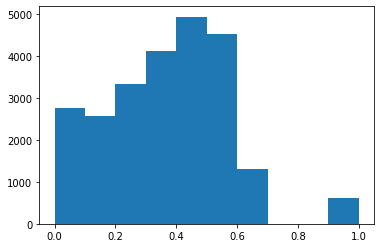

In [7]:
data_patients = pd.read_csv('data_patients_deep_learning.csv',
index_col=[0,1,2])
#print(data_patients["concensus"])
plt.hist(data_patients["concensus"])
for index, row in data_patients.iterrows():
  if data_patients.loc[index]["concensus"]<0:

    print(data_patients.loc[index]["concensus"])